In [7]:
import mujoco_py
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2r,pr2t,t2pr

import cv2

np.set_printoptions(precision=2)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Ready.


### Parsing `UR5e`

In [8]:
env = MuJoCoParserClass(name='UR5e',xml_path='../asset/ur5e/object_depth.xml')
print ("[%s] parsed."%(env.name))

[UR5e] parsed.


In [9]:
cam_infos = {"cam_distance":7.0, "cam_azimuth":80.0, "cam_elevation":-30.0, "cam_lookat":np.array([0,0,1.5])}
cam_infos["cam_lookat"][2]
cam_infos

{'cam_distance': 7.0,
 'cam_azimuth': 80.0,
 'cam_elevation': -30.0,
 'cam_lookat': array([0. , 0. , 1.5])}

In [10]:
cam_infos = env.set_cam_infos(cam_distance  = 1.5,
                    cam_azimuth   = 0.0,
                    cam_elevation = -90.0,
                    cam_lookat    = [0.6,0,1.4])
cam_infos

{'cam_distance': 1.5,
 'cam_azimuth': 0.0,
 'cam_elevation': -90.0,
 'cam_lookat': [0.6, 0, 1.4]}

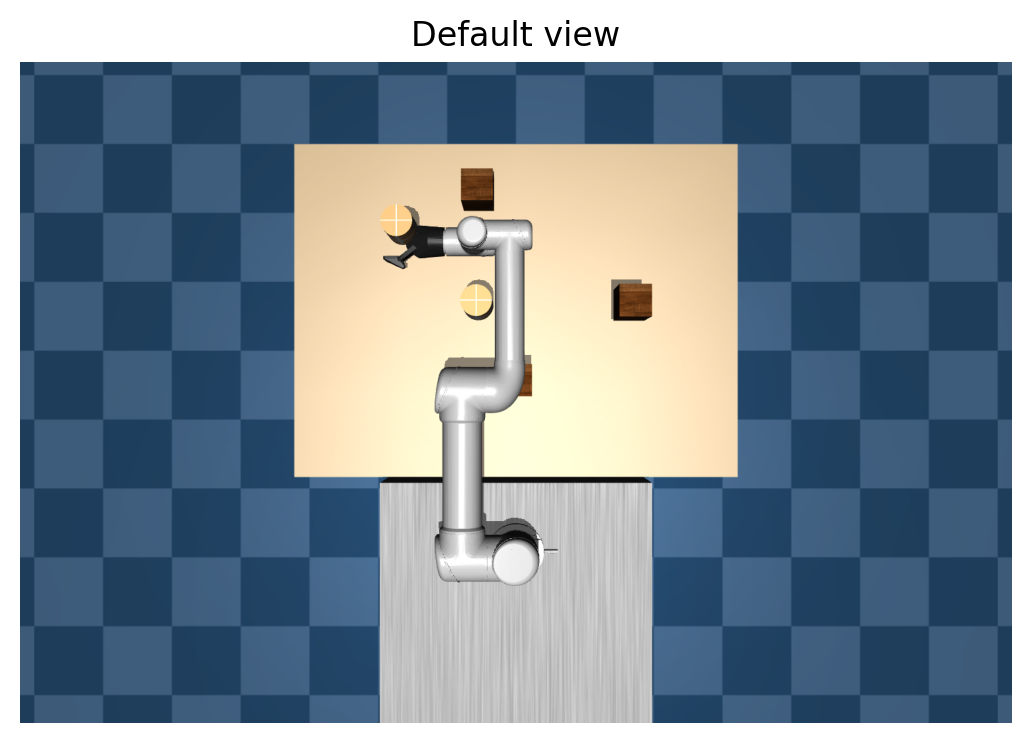

In [11]:
width = 1500
height = 1000

for _ in range(2):
    img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=False, camera_name="track")

plt.imshow(img); plt.axis('off')
plt.title("Default view")
plt.show()

### Get camera pose

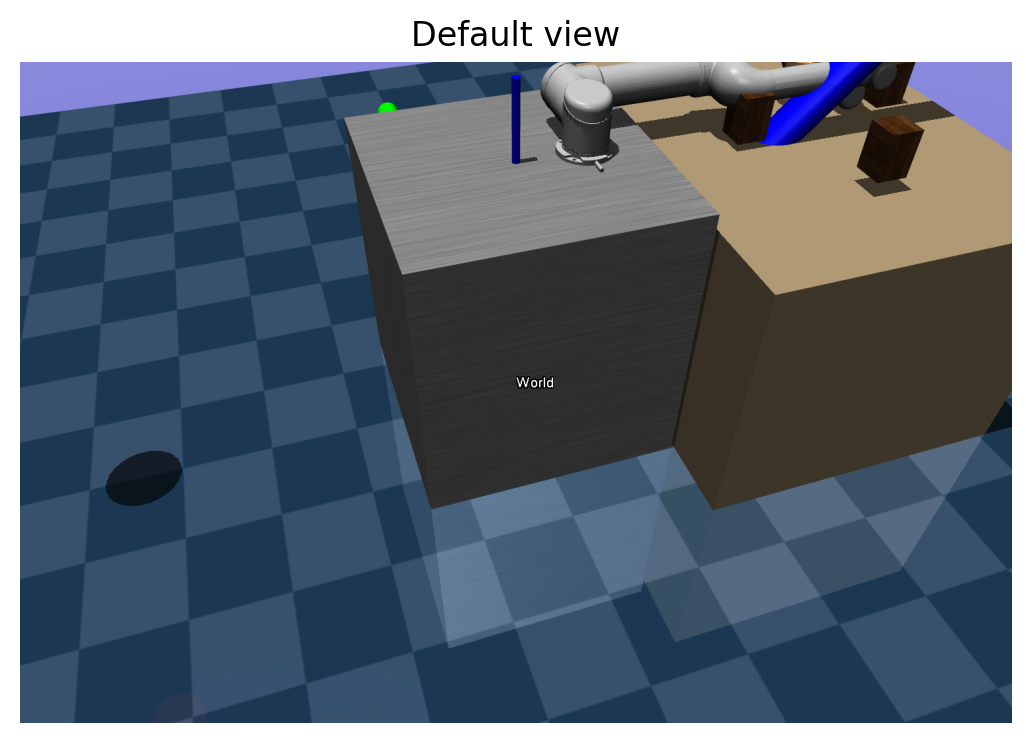

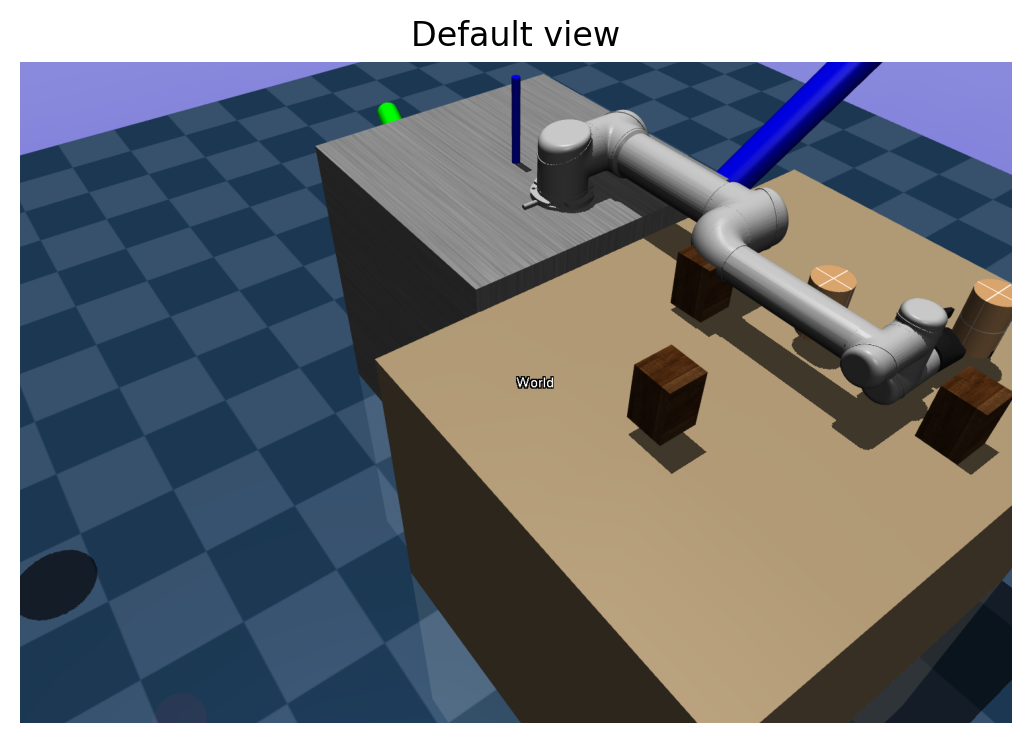

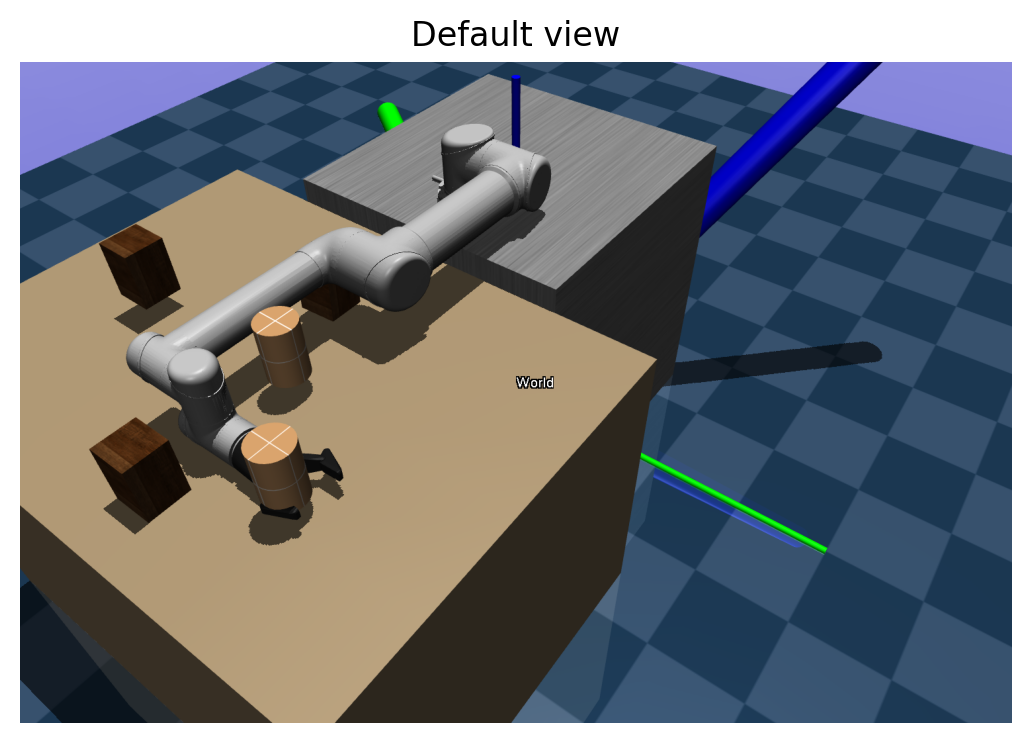

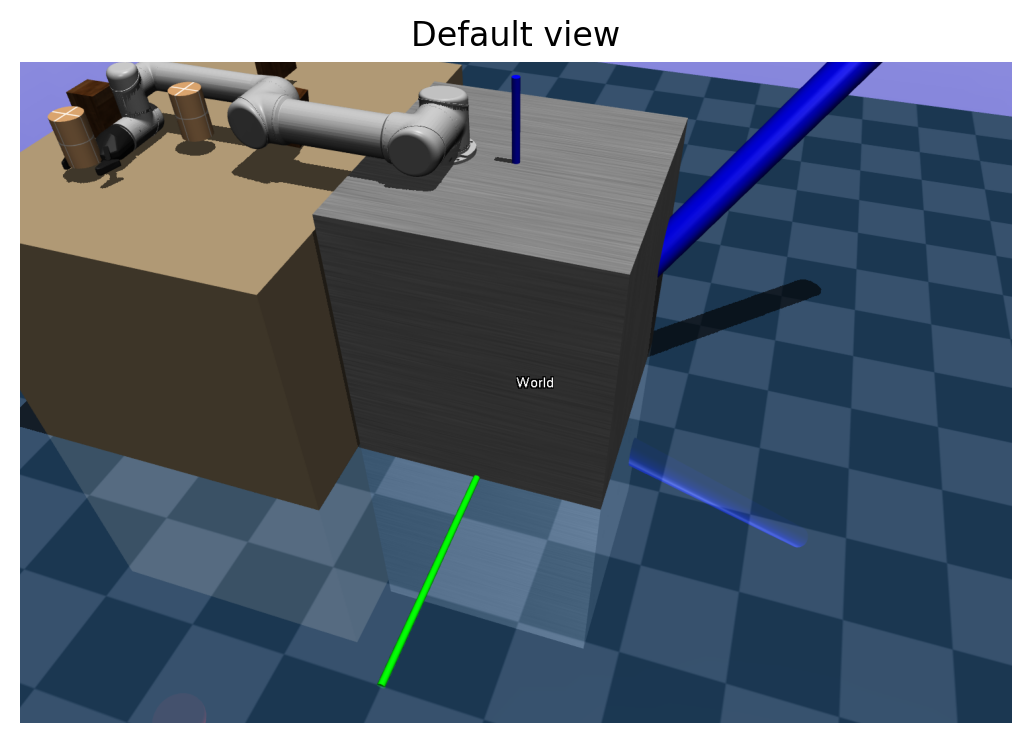

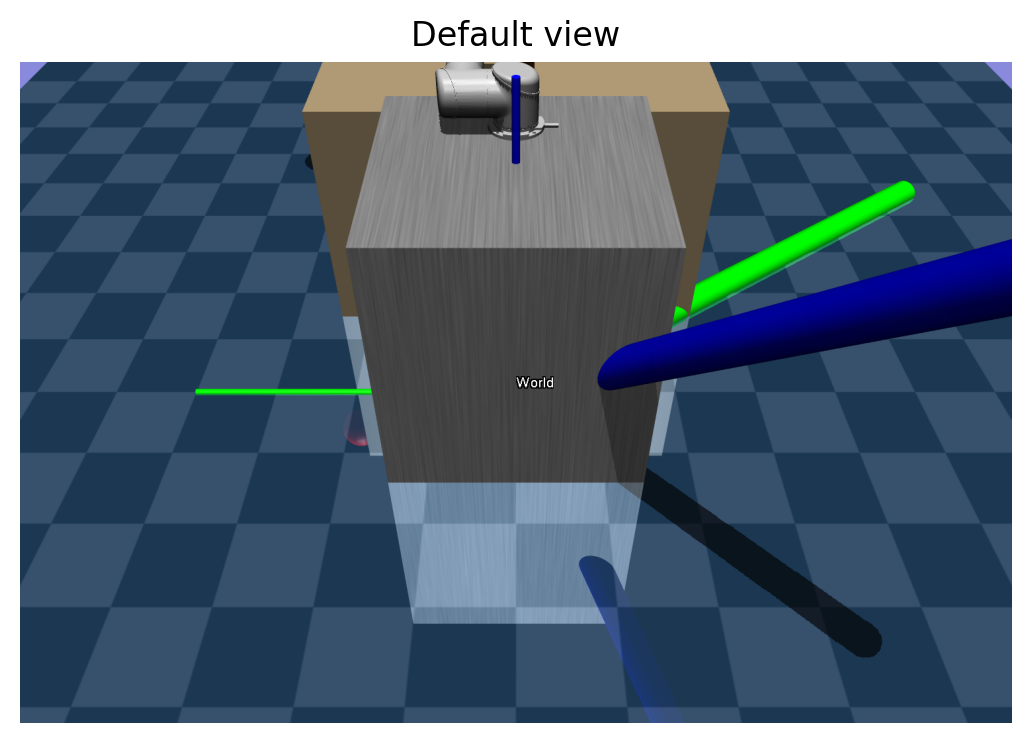

Done.


In [15]:
render_w = 1500
render_h = 1000

# Render
cam_infos = env.set_cam_infos(cam_azimuth   = 0,
        cam_distance  = 2.5,
        cam_elevation = -45, # -90~+90
        cam_lookat    = [0,0,0]
        )

env.reset()
max_tick = 5
while env.tick < max_tick:
    # Update
    env.step()
    
    # Get camera info
    if env.tick < 5:
        vi = env.get_viewer_info()
        p_viewer = vi['cam_lookat']
        R_viewer = rpy2r(np.deg2rad([0,-vi['cam_elevation'],vi['cam_azimuth']]))
        T_viewer = pr2t(p_viewer,R_viewer)
        T_marker = T_viewer @ pr2t(np.array([-2,0,0]),np.eye(3)) # minus translate w.r.t. x
        p_marker,R_marker = t2pr(T_marker)
    
    # Plot coordinate
    env.add_marker_coordinate(
        p=[0,0,0],R=np.eye(3),axis_len=1.0,axis_width=0.01,label='World')
    env.add_marker_coordinate(
        p=p_viewer,R=R_viewer,axis_len=2,axis_width=0.05,label='')
    env.add_marker_sphere(
        p=p_marker,radius=0.1,rgba=[1,0,0,1])
    
    # Render
    tick_rate = env.tick / max_tick
    MOVE_CAMERA = True
    if MOVE_CAMERA:
        # env.set_viewer(
        #     cam_azimuth   = 360.0*tick_rate,
        #     cam_elevation = 0.0*tick_rate - 45
        # )
        cam_infos = env.set_cam_infos(
            cam_azimuth   = 360.0*tick_rate,
            cam_elevation = 0.0*tick_rate - 45
        )
    # env.render() 

    for _ in range(2):
        img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=False, camera_name="track")

    plt.imshow(img); plt.axis('off')
    plt.title("Default view")
    plt.show()

    del env.viewer._markers[:]

    # for _ in range(10):
    #     img = env.viewer.read_pixels(width=render_w,height=render_h, depth=False)
    # img = cv2.flip(cv2.rotate(img,cv2.ROTATE_180),1) # 0:up<->down, 1:left<->right

    # plt.imshow(img)
    # plt.show()

print ("Done.")